In [9]:
import prody as pr
import numpy as np
import os
import subprocess
import rdkit as rd
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm.auto import tqdm
import pandas as pd
import math
from meeko import MoleculePreparation
from meeko import PDBQTWriterLegacy
from rdkit import IPythonConsole

#IPythonConsole.ipython_useSVG = True

In [10]:
! pwd

/home/ramin/Desktop/projects/dock_6hd4


## helper functions

In [11]:
# this list is to make sure that we only use the supported charachters by autogrid
supported_atypes = ['HD', 'C', 'A', 'N', 'NA', 'OA', 'F', 'P', 'SA', 'S',
                    'Cl', 'Br', 'I', 'Mg', 'Ca', 'Mn', 'Fe', 'Zn']

# the structure of the gpf file for autogrid4 as p
gpf = """npts NPTS_X NPTS_Y NPTS_Z
gridfld r.maps.fld
spacing 0.375
receptor_types RECTYPES
ligand_types HD C A N NA OA F P SA S Cl Br I
receptor r.pdbqt
gridcenter CENTER_X CENTER_Y CENTER_Z
smooth 0.5
map         r.HD.map
map         r.C.map
map         r.A.map
map         r.N.map
map         r.NA.map
map         r.OA.map
map         r.F.map
map         r.P.map
map         r.SA.map
map         r.S.map
map         r.Cl.map
map         r.Br.map
map         r.I.map
elecmap     r.e.map
dsolvmap    r.d.map
dielectric -0.1465
"""


vina_config = """
center_x = CENTER_X
center_y = CENTER_Y
center_z = CENTER_Z
size_x = SIZE_X
size_y = SIZE_Y
size_z = SIZE_Z
"""

In [12]:
def getrectypes(fname):
    command = 'cut -c 77-79 %s | sort -u' % fname
    out = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out = out.communicate()[0]
    rectypes = []
    for atype in out.split():
        atype = atype.strip().decode()
        if atype in supported_atypes:
            rectypes.append(atype)
    return ' '.join(rectypes)


# calculating grid box from the ligand size 
def calcbox(fname, pad, spacing=0.375) -> list:
    x_min = float('inf')
    y_min = float('inf')
    z_min = float('inf')
    x_max = float('-inf')
    y_max = float('-inf')
    z_max = float('-inf')
    with open(fname) as f:
        for line in f:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                x_max = max(x, x_max)
                y_max = max(y, y_max)
                z_max = max(z, z_max)
                x_min = min(x, x_min)
                y_min = min(y, y_min)
                z_min = min(z, z_min)
    center_x = (x_min + x_max) / 2.0
    center_y = (y_min + y_max) / 2.0
    center_z = (z_min + z_max) / 2.0
    npts_x = math.ceil((2 * pad + x_max - x_min) / spacing)  
    npts_y = math.ceil((2 * pad + y_max - y_min) / spacing)  
    npts_z = math.ceil((2 * pad + z_max - z_min) / spacing)  
    return [center_x, center_y, center_z, npts_x, npts_y, npts_z]


# this function writes the grid info for vina, vina algo dont accept map
def vina_conf(center_x, center_y, center_z,npts_x, npts_y, npts_z) -> list:
    center_x = center_x
    center_y = center_y
    center_z = center_z
    size_x = (npts_x * 0.75) / 2
    size_y = (npts_y * 0.75) / 2
    size_z = (npts_z * 0.75) / 2
    return [center_x, center_y, center_z, size_x, size_y, size_z]



def write_vinaconf_gpf(lPDBQT, rPDBQT, p, gpf=gpf, vconf=vina_config, gpf_out='./r.gpf', v_out='./v.txt'):
    rrectypes = getrectypes(rPDBQT)
    gridbox: list = calcbox(lPDBQT, p)
    vina_config: list = vina_conf(*gridbox)


    gpf = gpf.replace('RECTYPES',   rrectypes)
    gpf = gpf.replace('NPTS_X',     '%d' % gridbox[3])
    gpf = gpf.replace('NPTS_Y',     '%d' % gridbox[4])
    gpf = gpf.replace('NPTS_Z',     '%d' % gridbox[5])
    gpf = gpf.replace('CENTER_X',   '%.3f' % gridbox[0])
    gpf = gpf.replace('CENTER_Y',   '%.3f' % gridbox[1])
    gpf = gpf.replace('CENTER_Z',   '%.3f' % gridbox[2])
    
    vconf = vconf.replace('CENTER_X',   '%d' % vina_config[0])
    vconf = vconf.replace('CENTER_Y',   '%d' % vina_config[1])
    vconf = vconf.replace('CENTER_Z',   '%d' % vina_config[2])
    vconf = vconf.replace('SIZE_X',     '%d' % vina_config[3])
    vconf = vconf.replace('SIZE_Y',     '%d' % vina_config[4])
    vconf = vconf.replace('SIZE_Z',     '%d' % vina_config[5])

    with open(gpf_out, 'w') as f:
        f.write(gpf)
    with open(v_out, 'w') as f:
        f.write(vconf)

def run_autogrid(gpf, glgout='./r.glg'):
    command = f'autogrid4 -p {gpf} -l {glgout}'
    subprocess.run(command ,shell=True, stdout=subprocess.PIPE)
    print('success, map files created sucsussfully!')
    return 1

def run_prepare_receptor(rPDB):
    command = f'prepare_receptor -r {rPDB} -o r.pdbqt'
    try:
        subprocess.run(command, shell=True, stdout=subprocess.PIPE)
        print("success")
        return 1
    except Exception as e:
        print(f"error:{str(e)}")
        return 0

def run_obabel_ligand(lPDB):
    command_1 = f'obabel -ipdb {lPDB} -osdf -O ./l_with_no_h.sdf'
    subprocess.run(command_1, shell=True, stdout=subprocess.PIPE)
    return 1

def run_prepare_ligand(lSDF):
    command = f'mk_prepare_ligand.py -i {lSDF} -o l.pdbqt'
    subprocess.run(command, shell=True, stdout=subprocess.PIPE)
    return 1

def obabel_receptor(rPDB):
    command = f'obabel -i pdb {rPDB} -opdb -O ./r.pdb -h'
    subprocess.run(command, shell=True, stdout=subprocess.PIPE)
    return 1

In [13]:
def prepare_lig_rec(this_time, out=("./r.pdb", "./l.pdb")):
    mainPbd = pr.parsePDB(pr.fetchPDB(this_time, compressed=False)) # fetches the pdb file
    chains = mainPbd.getChids() # seprates the chain
    receptor = mainPbd.select('chain A protein') # lets hope there's always a A chain!
    pr.writePDB(out[0], receptor) # save the chain A as r.pdb
    # I encountered some problems with rdkit adding Hs to rec I decided to use obabel with -h flag
    # mol = rd.Chem.MolFromPDBFile('./r.pdb') # load the r.pdb in order to add hydrogens
    # receptor_H = rd.Chem.AddHs(mol, addCoords=True, addResidueInfo=True) # add Hs
    # rd.Chem.PDBWriter('./r.pdb').write(receptor_H) # write the hydrogenated r.pdb
    obabel_receptor(out[0])
    try:
        ligands = mainPbd.select('chain A not protein not water') # seprate the small molecules
        res, count = np.unique(ligands.getResnames(), return_counts=True) # as my experience the most reapeted name in .getResname method output is the main ligand 
        dict_res_count = dict(zip(res, count)) # create a dict from the resnames and there count
        main_res = list(dict_res_count.keys())[list(dict_res_count.values()).index(max(dict_res_count.values()))] # chose the most reapeted one
        ligand = ligands.select(f'resname {main_res}')
        pr.writePDB(out[1], ligand)
    except:
        return "No ligands"

In [14]:
def addHs(input_sdf, output_sdf):
    try:
        # Load the molecule without sanitization
        suppl = Chem.SDMolSupplier(input_sdf, sanitize=False)
        mol = next(suppl)
        if mol is None:
            raise ValueError("Failed to load molecule from SDF file")

        # Adjust nitrogen atoms (atomic number 7) with valence 4
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 7 and atom.GetTotalValence() == 4:
                atom.SetFormalCharge(1)  # Set to NH4+ if appropriate

            # Check for carbon atoms with invalid valence
            if atom.GetAtomicNum() == 6:  # Carbon atom
                valence = atom.GetTotalValence()
                if valence > 4:  # Carbon valence should not exceed 4
                    print(f"Warning: Carbon atom {atom.GetIdx()} has valence {valence}. Adjusting...")
                    # Reduce explicit valence by adjusting bonds or formal charge
                    atom.SetFormalCharge(0)  # Reset formal charge
                    for bond in atom.GetBonds():
                        if bond.GetBondType() == Chem.BondType.DOUBLE:
                            # Convert a double bond to single if possible to reduce valence
                            bond.SetBondType(Chem.BondType.SINGLE)
                            print(f"Converted double bond to single for atom {atom.GetIdx()}")

        # Attempt sanitization after adjustments
        Chem.SanitizeMol(mol, catchErrors=True)

        # Add hydrogens with 3D coordinates
        ligand_H = Chem.AddHs(mol, addCoords=True)
        
        # Write the output SDF file
        writer = Chem.SDWriter(output_sdf)
        writer.write(ligand_H)
        writer.close()
        print("Successfully added hydrogens to the molecule")
        return 1

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return 0

In [15]:
os.getcwd()

'/home/ramin/Desktop/projects/dock_6hd4'

In [16]:
def ligand_prep(ligmol, out):
    '''
    input:
    :ligmol: RDkit mol
    :out: output path and name
    output:
    :pdbqt: writes a pdbfile to the working directory
    '''
    mol_Hs = Chem.AddHs(ligmol, addCoords=True)
    AllChem.EmbedMolecule(mol_Hs, AllChem.ETKDG())
    AllChem.MMFFOptimizeMolecule(mol_Hs)
    preparator = MoleculePreparation(merge_these_atom_types=("H",))
    mol_setup = preparator.prepare(mol_Hs)[0]
    pdbqt_string, is_ok, error_msg = PDBQTWriterLegacy.write_string(mol_setup)
    if is_ok:
            #print(type(pdbqt_string) ,pdbqt_string, end="")
        with open(f'{out}.pdbqt', 'w') as pdbqt:
            pdbqt.writelines(pdbqt_string)
        return 1
    if not is_ok:
        return 0, str(error_msg)

    
    

## main part

### validation

In [56]:
os.chdir('..')

In [17]:
os.getcwd()

'/home/ramin/Desktop/projects/dock_6hd4'

In [22]:
prepare_lig_rec("5tx5", out=("./r.pdb", "./l.pdb"))

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./r.pdb)

1 molecule converted


In [10]:
run_obabel_ligand('./sti.pdb')

1 molecule converted


1

In [18]:
addHs('./STI.sdf', 'l_out.sdf')

Successfully added hydrogens to the molecule


1

In [19]:
run_prepare_ligand('./l_out.sdf')

1

In [69]:
! obabel -isdf ./l_out.sdf -omol2 -O sti.mol2

1 molecule converted


In [21]:
! obabel -i pdb ./6HD4_cleaned.pdb -opdb -O ./r.pdb -h

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./6HD4_cleaned.pdb)

1 molecule converted


In [22]:
! prepare_receptor -r r.pdb -o r.pdbqt

adding gasteiger charges to peptide
Unable to assign MAP type to atom N
Sorry, there are no Gasteiger parameters available for atom r:A:MET362:N
Unable to assign MAP type to atom N
Sorry, there are no Gasteiger parameters available for atom r:A:MET362:N
Sorry, there are no Gasteiger parameters available for atom r:A:MET362:O
Sorry, there are no Gasteiger parameters available for atom r:A:MET362:O
Unable to assign MAP type to atom N
Sorry, there are no Gasteiger parameters available for atom r:A:ALA363:N
Unable to assign MAP type to atom N
Sorry, there are no Gasteiger parameters available for atom r:A:SER368:N
Sorry, there are no Gasteiger parameters available for atom r:A:SER368:OG
Sorry, there are no Gasteiger parameters available for atom r:A:SER368:OG


In [52]:
write_vinaconf_gpf('l.pdbqt', 'r.pdbqt', 20)

In [53]:
! autogrid4 -p r.gpf -l r.glg

In [54]:
! adgpu --lfile l.pdbqt --ffile r.maps.fld --nrun 50

AutoDock-GPU version: v1.6

Running 1 docking calculation

Cuda device:                              NVIDIA GeForce MX450
Available memory on device:               1629 MB (total: 1682 MB)

CUDA Setup time 0.246720s
(Thread 5 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 537787
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.139136s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 537787 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |   -1.57 kcal/mol |   -2.78 +/-    0.40 kcal/mol |      11 |   -3.92 kcal/mol
          5 |        99158 |   -2.23 kcal/mol |   -5.84 +/-    1.67 k

### Testing 5hx6

In [22]:
os.getcwd()

'/home/ramin/Desktop/Thesis/ripk/ripk_1/5hx6'

In [32]:
os.chdir('../5hx6/')

In [33]:
prepare_lig_rec("5hx6", out=("./r.pdb", "./l.pdb"))

1 molecule converted


In [42]:
run_obabel_ligand('./l.pdb')

1 molecule converted


1

In [43]:
addHs('./l_with_no_h.sdf', 'l_out.sdf')

now the small molecule has Hs


1

In [44]:
run_prepare_ligand('./l_out.sdf')

1

In [45]:
! obabel -i pdb ./r.pdb -opdb -O ./r.pdb -h

1 molecule converted


In [46]:
! prepare_receptor -r r.pdb -o r.pdbqt

adding gasteiger charges to peptide


In [47]:
write_vinaconf_gpf('l.pdbqt', 'r.pdbqt', 10)

In [48]:
! autogrid4 -p r.gpf -l r.glg

In [49]:
! adgpu --lfile l.pdbqt --ffile r.maps.fld --nrun 50

AutoDock-GPU version: v1.6

Running 1 docking calculation

Cuda device:                              NVIDIA GeForce MX450
Available memory on device:               1630 MB (total: 1683 MB)

CUDA Setup time 0.241252s
(Thread 6 is setting up Job #1)

Running Job #1
    Using heuristics: (capped) number of evaluations set to 480000
    Local-search chosen method is: ADADELTA (ad)

Rest of Setup time 0.039673s

Executing docking runs, stopping automatically after either reaching 0.15 kcal/mol standard deviation of
the best molecules of the last 4 * 5 generations, 42000 generations, or 480000 evaluations:

Generations |  Evaluations |     Threshold    |  Average energy of best 10%  | Samples | Best Inter + Intra
------------+--------------+------------------+------------------------------+---------+-------------------
          0 |          150 |    2.51 kcal/mol |   -1.43 +/-    1.05 kcal/mol |       4 |   -2.64 kcal/mol
          5 |        45036 |    2.51 kcal/mol |   -6.69 +/-    2.62 k

### ripk3

In [40]:
os.chdir('../6oko/')

In [41]:
prepare_lig_rec("6oko", out=("./r.pdb", "./l.pdb"))

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is ./r.pdb)

1 molecule converted


## Lig docking

In [10]:
! pwd

/home/ramin/Desktop/Thesis/ripk


In [11]:
os.chdir('ripk_1/5hx6/')

### Docking drugs

In [24]:
ligands_df = pd.read_csv("../../libararies/ml_drugs_ro5.csv")

In [25]:
ligands_df.head()

,type,drugbank_id,groups,name,SMILES,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,...,Phi,mol,pred_pic50,IC50,mw,nhd,nha,clogp,rb,ro5
0,small molecule,DB00197,"['approved', 'investigational', 'withdrawn']",Troglitazone,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,441.160994,441.549,6.0,2.0,5.0,...,5.640935,<rdkit.Chem.rdchem.Mol object at 0x7747e1355e70>,7.207341,62.038213,441.160994,2,6,4.37426,5,OK
1,small molecule,DB00220,['approved'],Nelfinavir,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,567.313078,567.796,7.0,4.0,9.0,...,10.193207,<rdkit.Chem.rdchem.Mol object at 0x7747e29395b0>,7.182647,65.667918,567.313078,4,6,4.74762,9,OK
2,small molecule,DB00274,"['approved', 'investigational']",Cefmetazole,[H][C@]12SCC(CSC3=NN=NN3C)=C(N1C(=O)[C@]2(NC(=...,471.045330,471.546,12.0,2.0,9.0,...,6.906617,<rdkit.Chem.rdchem.Mol object at 0x7747e29391c0>,7.178785,66.254392,471.045330,2,12,-0.72832,9,OK
3,small molecule,DB00275,"['approved', 'investigational']",Olmesartan,CCCC1=NC(=C(N1CC1=CC=C(C=C1)C1=C(C=CC=C1)C1=NN...,446.206639,446.511,9.0,3.0,8.0,...,6.061009,<rdkit.Chem.rdchem.Mol object at 0x7747e2939460>,7.111199,77.410718,446.206639,3,7,3.65660,8,OK
4,small molecule,DB00604,"['approved', 'investigational', 'withdrawn']",Cisapride,CO[C@H]1CN(CCCOC2=CC=C(F)C=C2)CC[C@H]1NC(=O)C1...,465.183062,465.953,7.0,3.0,9.0,...,8.551572,<rdkit.Chem.rdchem.Mol object at 0x7747e19ff4c0>,7.101665,79.128960,465.183062,2,6,3.35810,9,OK


In [26]:
ligands_df['mol'] = ligands_df['SMILES'].apply(Chem.MolFromSmiles)

In [27]:
ligands_df.head()

,type,drugbank_id,groups,name,SMILES,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,...,Phi,mol,pred_pic50,IC50,mw,nhd,nha,clogp,rb,ro5
0,small molecule,DB00197,"['approved', 'investigational', 'withdrawn']",Troglitazone,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,441.160994,441.549,6.0,2.0,5.0,...,5.640935,<rdkit.Chem.rdchem.Mol object at 0x7b84dd718f20>,7.207341,62.038213,441.160994,2,6,4.37426,5,OK
1,small molecule,DB00220,['approved'],Nelfinavir,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,567.313078,567.796,7.0,4.0,9.0,...,10.193207,<rdkit.Chem.rdchem.Mol object at 0x7b84dd719460>,7.182647,65.667918,567.313078,4,6,4.74762,9,OK
2,small molecule,DB00274,"['approved', 'investigational']",Cefmetazole,[H][C@]12SCC(CSC3=NN=NN3C)=C(N1C(=O)[C@]2(NC(=...,471.045330,471.546,12.0,2.0,9.0,...,6.906617,<rdkit.Chem.rdchem.Mol object at 0x7b84dd7190e0>,7.178785,66.254392,471.045330,2,12,-0.72832,9,OK
3,small molecule,DB00275,"['approved', 'investigational']",Olmesartan,CCCC1=NC(=C(N1CC1=CC=C(C=C1)C1=C(C=CC=C1)C1=NN...,446.206639,446.511,9.0,3.0,8.0,...,6.061009,<rdkit.Chem.rdchem.Mol object at 0x7b84dd719150>,7.111199,77.410718,446.206639,3,7,3.65660,8,OK
4,small molecule,DB00604,"['approved', 'investigational', 'withdrawn']",Cisapride,CO[C@H]1CN(CCCOC2=CC=C(F)C=C2)CC[C@H]1NC(=O)C1...,465.183062,465.953,7.0,3.0,9.0,...,8.551572,<rdkit.Chem.rdchem.Mol object at 0x7b84dd7194d0>,7.101665,79.128960,465.183062,2,6,3.35810,9,OK


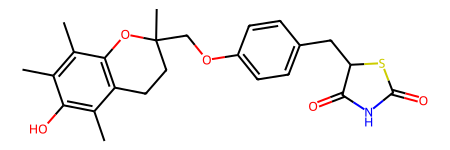

In [29]:
ligands_df.values[0][48]

In [30]:
failed = []
for row in ligands_df.values:
    os.mkdir(row[3])
    try:
        ligand_prep(row[48], out=f"{row[3]}/l")
    except Exception as e:
        os.removedirs(row[0])
        failed.append(row)

In [31]:
len(failed)

0

##### dock for wild type

In [33]:
from tqdm.auto import tqdm

In [34]:
to_dock_dirs = [x for x in os.listdir() if x in ligands_df.name.to_list()]

In [38]:
os.getcwd()

'/home/ramin/Desktop/Thesis/ripk/ripk_1/5hx6'

In [36]:
import time
#os.chdir('./savolotinib_6SDE/')

In [39]:
for idx, dir_ in enumerate(tqdm(to_dock_dirs, total=len(to_dock_dirs))):
    if (idx>10 and idx%10 == 0):
        print('cooling down')
        time.sleep(20)
    
    if not os.path.exists(f'{dir_}/l_wild.dlg'):
        os.chdir(dir_)
        print(f"Docking in {dir_}")
        command = f"/home/ramin/Desktop/personal/cheminfo/adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild"
        try:
            
            result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(f"Command output: {result.stdout}")
            if result.stderr:
                print(f"Command stderr: {str(result.stderr)}")
        except subprocess.CalledProcessError as e:
            print(f"Command failed with error: {e}")
            print(f"Error output: {e.stderr}")

        os.chdir('../')  
    else:
        pass


  0%|          | 0/30 [00:00<?, ?it/s]

Docking in Troglitazone
Docking in Nelfinavir
Docking in Cefmetazole
Docking in Olmesartan
Docking in Cisapride
Docking in Glyburide
Docking in Cefapirin
Docking in Gliquidone
Docking in Cefamandole
Docking in Cefazolin
Docking in Quinidine_barbiturate
Docking in Pimavanserin
Docking in Tirbanibulin
Docking in Amisulpride
Docking in Fesoterodine
Docking in Sofosbuvir
Docking in Empagliflozin
Docking in Eliglustat
Docking in Paritaprevir
Docking in Carindacillin
cooling down
Docking in Naldemedine
Docking in Ertugliflozin
Docking in Copanlisib
Docking in Fedratinib
Docking in Sotagliflozin
Docking in Oteseconazole
Docking in Sultopride
Docking in Tritoqualine
Docking in Cefamandole_nafate
Docking in Elexacaftor


In [40]:
! pwd

/home/ramin/Desktop/Thesis/ripk/ripk_1/5hx6


In [44]:
data = []
for dir__ in [x for x in os.listdir() if x in ligands_df.name.to_list()]:
    if os.path.exists(f'{dir__}/l_wild.dlg'):
        lines = []
        with open(f'{dir__}/l_wild.dlg') as f:
            lines = f.readlines()
        eng = [float(lines[idx+4].split("|")[3].strip()) for idx,x in enumerate(lines) if x.startswith('Clus')][0]
        data.append((dir__, eng))
            

In [45]:
data = pd.DataFrame.from_records([x for x in data], columns=['name', 'deltaG'])

In [46]:
data.sort_values('deltaG').head()

,name,deltaG
20,Naldemedine,-12.37
3,Olmesartan,-11.57
7,Gliquidone,-11.48
1,Nelfinavir,-11.47
23,Fedratinib,-11.25


In [47]:
data.to_csv("drugs_ripk.csv", index=False)

In [52]:
(ligands_df
 #.query("db in @ligands_df.db.values")
 .assign(
     deltaG_ripk1 = data.deltaG.values
 )
 #[['name', 'deltaG', 'SMILES']]
 .sort_values('deltaG_ripk1')
 
).to_csv('drugs_ripk1.csv', index=False)

In [53]:
import matplotlib.pyplot as plt

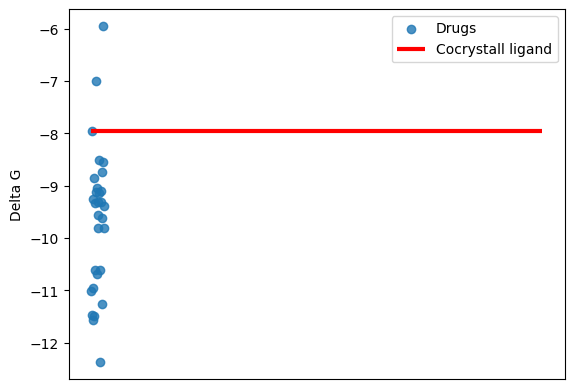

In [54]:
plt.scatter(x=data.index.values,y=data.deltaG.values, alpha=0.8, label='Drugs')
plt.yticks(range(-13,0))
plt.ylabel('Delta G')
plt.xticks([])
plt.hlines(y=float(-7.96), xmin=0, xmax=1000, lw=3, colors='red', label='Cocrystall ligand')
plt.legend()
plt.show()
#plt.gca().invert_yaxis()

### Docking pubchem analogous

In [12]:
ligands_df = pd.read_csv("../../ml_pubchem.csv")

In [14]:
ligands_df.head()

,SMILES,mol,mw,logp,hbd,hba,rd,exactmw,amw,lipinskiHBA,...,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi,pred_pic50,IC50
0,Cc1cccc(-n2nc(C(=O)NCCOc3ccccc3)nc2-c2ccccc2)c1,<rdkit.Chem.rdchem.Mol object at 0x7661e04d8b30>,398.174276,4.05152,1,6,7,398.174276,398.466,6.0,...,4.488005,4.488005,3.051313,-3.93,19.389189,9.046234,4.548551,5.846638,7.302074,49.879899
1,Cc1ccc(C)c(-n2c(C)nnc2SCC(=O)NCCOc2ccccc2)c1,<rdkit.Chem.rdchem.Mol object at 0x7661e04d9150>,396.161997,3.47986,1,6,8,396.161997,396.516,6.0,...,4.169230,4.169230,2.731282,-2.80,19.947729,9.412510,5.132275,6.705650,7.186217,65.130242
2,CCOc1ccc(C(=O)NCC(=O)Nc2ccc(-c3n[nH]c(C)n3)cc2...,<rdkit.Chem.rdchem.Mol object at 0x7661e04db060>,379.164440,2.54732,3,8,7,379.164440,379.420,8.0,...,3.861081,3.861081,2.511440,-3.68,19.091889,8.806944,4.939566,6.005043,7.132931,73.632449
3,COCCCOc1ccccc1NC(=O)NCCc1nnc2n1CCCCC2,<rdkit.Chem.rdchem.Mol object at 0x7661e04d6180>,387.227040,2.78400,2,8,9,387.227040,387.484,8.0,...,4.705899,4.705899,3.265716,-2.61,20.132710,10.653961,5.691386,7.660468,7.048383,89.457600
4,Cc1cccc(OCCNC(=O)CSc2nnc(C)n2-c2ccccc2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7661e04d7920>,396.161997,3.47986,1,6,8,396.161997,396.516,6.0,...,4.166379,4.166379,2.773669,-2.80,19.947729,9.412510,5.132275,6.705650,7.129888,74.150053


In [16]:
ligands_df.shape

(33, 52)

In [17]:
ligands_df['mol'] = ligands_df['SMILES'].apply(Chem.MolFromSmiles)

In [18]:
ligands_df.head()

,SMILES,mol,mw,logp,hbd,hba,rd,exactmw,amw,lipinskiHBA,...,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi,pred_pic50,IC50
0,Cc1cccc(-n2nc(C(=O)NCCOc3ccccc3)nc2-c2ccccc2)c1,<rdkit.Chem.rdchem.Mol object at 0x73fa552a0350>,398.174276,4.05152,1,6,7,398.174276,398.466,6.0,...,4.488005,4.488005,3.051313,-3.93,19.389189,9.046234,4.548551,5.846638,7.302074,49.879899
1,Cc1ccc(C)c(-n2c(C)nnc2SCC(=O)NCCOc2ccccc2)c1,<rdkit.Chem.rdchem.Mol object at 0x73fa552a03c0>,396.161997,3.47986,1,6,8,396.161997,396.516,6.0,...,4.169230,4.169230,2.731282,-2.80,19.947729,9.412510,5.132275,6.705650,7.186217,65.130242
2,CCOc1ccc(C(=O)NCC(=O)Nc2ccc(-c3n[nH]c(C)n3)cc2...,<rdkit.Chem.rdchem.Mol object at 0x73fa552a0430>,379.164440,2.54732,3,8,7,379.164440,379.420,8.0,...,3.861081,3.861081,2.511440,-3.68,19.091889,8.806944,4.939566,6.005043,7.132931,73.632449
3,COCCCOc1ccccc1NC(=O)NCCc1nnc2n1CCCCC2,<rdkit.Chem.rdchem.Mol object at 0x73fa552a04a0>,387.227040,2.78400,2,8,9,387.227040,387.484,8.0,...,4.705899,4.705899,3.265716,-2.61,20.132710,10.653961,5.691386,7.660468,7.048383,89.457600
4,Cc1cccc(OCCNC(=O)CSc2nnc(C)n2-c2ccccc2C)c1,<rdkit.Chem.rdchem.Mol object at 0x73fa552a0510>,396.161997,3.47986,1,6,8,396.161997,396.516,6.0,...,4.166379,4.166379,2.773669,-2.80,19.947729,9.412510,5.132275,6.705650,7.129888,74.150053


In [21]:
ligands_df['name'] = [f"pubchem_{x}" for x in range(len(ligands_df))]

In [31]:
ligands_df.values[0][52]

'pubchem_0'

In [32]:
failed = []
for row in ligands_df.values:
    os.mkdir(row[52])
    try:
        ligand_prep(row[1], out=f"{row[52]}/l")
    except Exception as e:
        os.removedirs(row[52])
        failed.append(row)

In [34]:
to_dock_dirs = [x for x in os.listdir() if x in ligands_df.name.to_list()]

In [36]:
! pwd

/home/ramin/Desktop/Thesis/ripk/ripk_1/5hx6


In [22]:
import time

In [39]:
for idx, dir_ in enumerate(tqdm(to_dock_dirs, total=len(to_dock_dirs))):
    if (idx>10 and idx%10 == 0):
        print('cooling down')
        time.sleep(20)
    
    if not os.path.exists(f'{dir_}/l_wild.dlg'):
        os.chdir(dir_)
        print(f"Docking in {dir_}")
        command = f"/home/ramin/Desktop/personal/cheminfo/adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild"
        try:
            
            result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(f"Command output: {result.stdout}")
            if result.stderr:
                print(f"Command stderr: {str(result.stderr)}")
        except subprocess.CalledProcessError as e:
            print(f"Command failed with error: {e}")
            print(f"Error output: {e.stderr}")

        os.chdir('../')  
    else:
        pass


  0%|          | 0/33 [00:00<?, ?it/s]

cooling down
Docking in pubchem_20
Docking in pubchem_21
Docking in pubchem_22
Docking in pubchem_23
Docking in pubchem_24
Docking in pubchem_25
Docking in pubchem_26
Docking in pubchem_27
Docking in pubchem_28
Docking in pubchem_29
cooling down
Docking in pubchem_30
Docking in pubchem_31
Docking in pubchem_32


In [40]:
data = []
for dir__ in [x for x in os.listdir() if x in ligands_df.name.to_list()]:
    if os.path.exists(f'{dir__}/l_wild.dlg'):
        lines = []
        with open(f'{dir__}/l_wild.dlg') as f:
            lines = f.readlines()
        eng = [float(lines[idx+4].split("|")[3].strip()) for idx,x in enumerate(lines) if x.startswith('Clus')][0]
        data.append((dir__, eng))

In [41]:
data = pd.DataFrame.from_records([x for x in data], columns=['name', 'deltaG'])

In [44]:
(ligands_df
 #.query("db in @ligands_df.db.values")
 .assign(
     deltaG_ripk1 = data.deltaG.values
 )
 #[['name', 'deltaG', 'SMILES']]
 .sort_values('deltaG_ripk1')
 
).to_csv('pubchem_ripk1.csv', index=False)

### Amines

In [10]:
! pwd

/home/ramin/Desktop/Thesis/ripk


In [11]:
os.chdir('./ripk_1/5hx6/')

In [12]:
ligands_df = pd.read_csv("../../ml_amin.csv")

In [19]:
ligands_df.head()

,SMILES,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,...,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi,mol,pred_pic50,IC50,name
0,COCC(=O)c1cc2sc(NC(=O)C(C)N3C(=O)c4ccccc4C3=O)...,457.049919,457.895,8.0,1.0,6.0,1.0,7.0,31.0,47.0,...,3.311105,-3.140000,21.105774,8.180098,3.713432,5.569267,<rdkit.Chem.rdchem.Mol object at 0x7538d5a93300>,7.000889,99.795440,amin_0
1,O=C(OCC(=O)c1cc2sc(NC(=O)C(F)(F)C(F)F)nc2cc1Cl...,474.006418,474.819,6.0,1.0,7.0,1.0,6.0,31.0,42.0,...,2.361500,-3.050000,22.631102,8.982022,4.995661,6.557195,<rdkit.Chem.rdchem.Mol object at 0x7538d5a93450>,7.040881,91.016330,amin_1
2,O=C(COc1ccc(F)c(Cl)c1)c1cc2sc(NC(=O)C3CCOCC3)n...,466.056562,466.893,6.0,1.0,6.0,1.0,6.0,31.0,48.0,...,3.176036,-2.620000,21.605952,9.252392,5.001915,6.448605,<rdkit.Chem.rdchem.Mol object at 0x7538d5a93680>,7.117684,76.263391,amin_2
3,O=Bc1cccc(C(=O)Nc2nc3cc(F)c(C(=O)COc4ccc(F)c(C...,484.026742,484.676,6.0,1.0,7.0,1.0,6.0,33.0,45.0,...,2.931313,-3.495065,22.690087,9.555729,5.125603,6.570313,<rdkit.Chem.rdchem.Mol object at 0x7538d5a937d0>,7.002104,99.516643,amin_3
4,CC(=O)NC(C)C(=O)Nc1nc2cc(Cl)c(C(=O)CCc3ccc4c(c...,473.081219,473.938,8.0,2.0,7.0,2.0,7.0,32.0,52.0,...,3.288617,-3.170000,22.039299,9.134951,4.837643,6.291498,<rdkit.Chem.rdchem.Mol object at 0x7538d5a93a70>,7.027426,93.880146,amin_4


In [15]:
ligands_df.shape

(377, 47)

In [16]:
ligands_df['mol'] = ligands_df['SMILES'].apply(Chem.MolFromSmiles)

In [17]:
ligands_df['name'] = [f"amin_{x}" for x in range(len(ligands_df))]

In [18]:
ligands_df.values[0][47]

'amin_0'

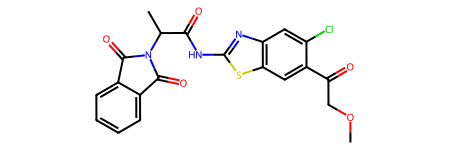

In [20]:
ligands_df.values[0][44]

In [28]:
to_dock_dirs = [x for x in os.listdir() if x in ligands_df.name.to_list()]

In [23]:
failed = []
for row in ligands_df.values:
    os.mkdir(row[47])
    try:
        ligand_prep(row[44], out=f"{row[47]}/l")
    except Exception as e:
        os.removedirs(row[47])
        failed.append(row)

[13:59:10] UFFTYPER: Unrecognized atom type: B_1 (1)
[13:59:11] UFFTYPER: Unrecognized atom type: B_1 (1)
[13:59:12] UFFTYPER: Unrecognized atom type: B_1 (1)
[13:59:13] UFFTYPER: Unrecognized atom type: B_1 (1)


In [30]:
for idx, dir_ in enumerate(tqdm(to_dock_dirs, total=len(to_dock_dirs))):
    if (idx>10 and idx%10 == 0):
        print('cooling down')
        time.sleep(20)
    
    if not os.path.exists(f'{dir_}/l_wild.dlg'):
        os.chdir(dir_)
        print(f"Docking in {dir_}")
        command = f"/home/ramin/Desktop/personal/cheminfo/adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild"
        try:
            
            result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(f"Command output: {result.stdout}")
            if result.stderr:
                print(f"Command stderr: {str(result.stderr)}")
        except subprocess.CalledProcessError as e:
            print(f"Command failed with error: {e}")
            print(f"Error output: {e.stderr}")

        os.chdir('../')  
    else:
        pass


  0%|          | 0/377 [00:00<?, ?it/s]

Docking in amin_0
Docking in amin_1
Docking in amin_2
Docking in amin_3
Docking in amin_4
Docking in amin_5
Docking in amin_6
Docking in amin_7
Docking in amin_8
Docking in amin_9
Docking in amin_10
Docking in amin_11
Docking in amin_12
Docking in amin_13
Docking in amin_14
Docking in amin_15
Docking in amin_16
Docking in amin_17
Docking in amin_18
Docking in amin_19
cooling down
Docking in amin_20
Docking in amin_21
Docking in amin_22
Docking in amin_23
Docking in amin_24
Docking in amin_25
Docking in amin_26
Docking in amin_27
Docking in amin_28
Docking in amin_29
cooling down
Docking in amin_30
Docking in amin_31
Docking in amin_32
Docking in amin_33
Docking in amin_34
Docking in amin_35
Docking in amin_36
Docking in amin_37
Docking in amin_38
Docking in amin_39
cooling down
Docking in amin_40
Docking in amin_41
Docking in amin_42
Docking in amin_43
Docking in amin_44
Docking in amin_45
Docking in amin_46
Docking in amin_47
Docking in amin_48
Docking in amin_49
cooling down
Docking 

In [31]:
data = []
for dir__ in [x for x in os.listdir() if x in ligands_df.name.to_list()]:
    if os.path.exists(f'{dir__}/l_wild.dlg'):
        lines = []
        with open(f'{dir__}/l_wild.dlg') as f:
            lines = f.readlines()
        eng = [float(lines[idx+4].split("|")[3].strip()) for idx,x in enumerate(lines) if x.startswith('Clus')][0]
        data.append((dir__, eng))

In [32]:
data = pd.DataFrame.from_records([x for x in data], columns=['name', 'deltaG'])

In [34]:
data.shape

(373, 2)

In [40]:
pd.merge(ligands_df, data, on="name").sort_values('deltaG').to_csv('amin_ripk1.csv', index=False)


### Trimethoxy

In [9]:
! pwd

/home/ramin/Desktop/Thesis/ripk


In [10]:
os.chdir('./ripk_1/5hx6/')

In [11]:
ligands_df = pd.read_csv("../../ml_tri.csv")

In [19]:
ligands_df.head()

,Unnamed: 0,SMILES,mol,mw,logp,hbd,hba,rd,exactmw,amw,...,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi,pred_pic50,IC50,name
0,29,COc1cc(C(=O)Nc2nnn[nH]2)cc(OC)c1OC,<rdkit.Chem.rdchem.Mol object at 0x76cbab4fcc10>,279.096754,0.4778,2,9,5,279.096754,279.256,...,2.504193,1.604003,-2.84,13.588400,5.867032,2.604894,3.986179,7.031155,93.077539,tri_0
1,139,COc1cc(C(=O)NCCN2CCNC(=O)C2)cc(OC)c1OC,<rdkit.Chem.rdchem.Mol object at 0x76cbab4fcc80>,337.163771,-0.1260,2,8,7,337.163771,337.376,...,3.757918,2.524134,-2.48,17.867353,8.393980,4.286748,6.249092,7.084256,82.365304,tri_1
2,173,CCN(CC)C1(CNC(=O)c2cc(OC)c(OC)c(OC)c2)CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x76cbab4fccf0>,378.251858,3.4869,1,6,9,378.251858,378.513,...,5.723447,4.268176,-1.95,21.351207,9.832103,4.667928,7.775084,7.080838,83.016090,tri_2
3,286,COc1cc(C(=O)NCC2(N3CCCCC3)CCCCC2)cc(OC)c1OC,<rdkit.Chem.rdchem.Mol object at 0x76cbab4fcd60>,390.251858,3.6310,1,6,7,390.251858,390.524,...,6.316068,4.741998,-1.95,20.775786,9.501580,4.373867,7.050099,7.072964,84.534854,tri_3
4,287,COc1cc(C(=O)NCC2(N3CCOCC3)CCCCC2)cc(OC)c1OC,<rdkit.Chem.rdchem.Mol object at 0x76cbab4fcdd0>,392.231122,2.4773,1,7,7,392.231122,392.496,...,5.971090,4.411442,-1.99,20.736789,9.474278,4.357898,7.016647,7.085618,82.107250,tri_4


In [20]:
ligands_df.shape

(278, 54)

In [16]:
ligands_df['mol'] = ligands_df.SMILES.apply(Chem.MolFromSmiles)

In [18]:
ligands_df['name'] = [f"tri_{x}" for x in range(len(ligands_df))]

In [22]:
ligands_df.values[0][53]

'tri_0'

In [23]:
failed = []
for row in ligands_df.values:
    os.mkdir(row[53])
    try:
        ligand_prep(row[2], out=f"{row[53]}/l")
    except Exception as e:
        os.removedirs(row[53])
        failed.append(row)

[13:26:40] UFFTYPER: Warning: hybridization set to SP3 for atom 12


In [37]:
to_dock_dirs = [x for x in os.listdir() if x in ligands_df.name.to_list()]

In [26]:
import time

In [39]:
for idx, dir_ in enumerate(tqdm(to_dock_dirs, total=len(to_dock_dirs))):
    if (idx>10 and idx%10 == 0):
        print('cooling down')
        time.sleep(50)
    
    if not os.path.exists(f'{dir_}/l_wild.dlg'):
        os.chdir(dir_)
        print(f"Docking in {dir_}")
        command = f"/home/ramin/Desktop/personal/cheminfo/adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild"
        try:
            
            result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(f"Command output: {result.stdout}")
            if result.stderr:
                print(f"Command stderr: {str(result.stderr)}")
        except subprocess.CalledProcessError as e:
            print(f"Command failed with error: {e}")
            print(f"Error output: {e.stderr}")

        os.chdir('../')  
    else:
        pass

  0%|          | 0/278 [00:00<?, ?it/s]

Docking in tri_8
Docking in tri_9
Docking in tri_17
Docking in tri_18
Docking in tri_19
cooling down
Docking in tri_20
Docking in tri_21
Docking in tri_22
Docking in tri_23
Docking in tri_24
Docking in tri_25
Docking in tri_26
Docking in tri_27
Docking in tri_28
Docking in tri_29
cooling down
Docking in tri_30
Docking in tri_31
Docking in tri_32
Docking in tri_33
Docking in tri_34
Docking in tri_35
Docking in tri_36
Docking in tri_37
Docking in tri_38
Docking in tri_39
cooling down
Docking in tri_40
Docking in tri_41
Docking in tri_42
Docking in tri_43
Docking in tri_44
Docking in tri_45
Docking in tri_46
Docking in tri_47
Docking in tri_48
Docking in tri_49
cooling down
Docking in tri_50
Docking in tri_51
Docking in tri_52
Docking in tri_53
Docking in tri_54
Docking in tri_55
Docking in tri_56
Docking in tri_57
Docking in tri_58
Docking in tri_59
cooling down
Docking in tri_60
Docking in tri_61
Docking in tri_62
Docking in tri_63
Docking in tri_64
Docking in tri_65
Docking in tri_66
D

In [40]:
data = []
for dir__ in [x for x in os.listdir() if x in ligands_df.name.to_list()]:
    if os.path.exists(f'{dir__}/l_wild.dlg'):
        lines = []
        with open(f'{dir__}/l_wild.dlg') as f:
            lines = f.readlines()
        eng = [float(lines[idx+4].split("|")[3].strip()) for idx,x in enumerate(lines) if x.startswith('Clus')][0]
        data.append((dir__, eng))

In [42]:
data = pd.DataFrame.from_records([x for x in data], columns=['name', 'deltaG'])

In [46]:
pd.merge(ligands_df, data, on="name").sort_values('deltaG').drop(columns='Unnamed: 0').to_csv('tri_ripk1.csv', index=False)

In [3]:
os.chdir("ripk_1/5hx6/")

In [21]:
df = pd.read_csv("amin_ripk1.csv")

In [22]:
df.head()

,SMILES,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,...,hallKierAlpha,kappa1,kappa2,kappa3,Phi,mol,pred_pic50,IC50,name,deltaG
0,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)C(O)c4ccccc4)sc3c...,465.091390,465.962,6.0,3.0,6.0,3.0,5.0,32.0,52.0,...,-3.26,21.952593,9.480624,4.802075,6.503884,<rdkit.Chem.rdchem.Mol object at 0x7538d56bbc30>,7.072100,84.703297,amin_298,-12.58
1,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)Cc4ccc(OC)c(C)c4)...,477.152241,477.561,6.0,2.0,7.0,2.0,5.0,34.0,58.0,...,-3.78,23.380599,10.007828,5.231476,6.882029,<rdkit.Chem.rdchem.Mol object at 0x7538d56bce40>,7.684931,20.657070,amin_338,-12.33
2,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)c4ccc(OC)c(O)c4)s...,481.086305,481.961,7.0,3.0,6.0,3.0,6.0,33.0,53.0,...,-3.62,22.569549,9.477399,4.916517,6.481837,<rdkit.Chem.rdchem.Mol object at 0x7538d56bb530>,7.408028,39.081601,amin_282,-12.32
3,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)C4Cc5ccccc5O4)sc3...,477.091390,477.973,6.0,2.0,5.0,2.0,5.0,33.0,53.0,...,-3.42,21.426993,8.843775,4.421156,5.742288,<rdkit.Chem.rdchem.Mol object at 0x7538d56b78b0>,7.582619,26.144528,amin_145,-12.31
4,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)Cc4ccc5c(c4)OCO5)...,493.086305,493.972,7.0,2.0,6.0,2.0,6.0,34.0,54.0,...,-3.62,22.186031,9.323098,4.686162,6.083604,<rdkit.Chem.rdchem.Mol object at 0x7538d56b6c00>,7.374746,42.194289,amin_116,-12.30


In [24]:
df.query("deltaG <= -8.84")

,SMILES,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,...,hallKierAlpha,kappa1,kappa2,kappa3,Phi,mol,pred_pic50,IC50,name,deltaG
0,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)C(O)c4ccccc4)sc3c...,465.091390,465.962,6.0,3.0,6.0,3.0,5.0,32.0,52.0,...,-3.26,21.952593,9.480624,4.802075,6.503884,<rdkit.Chem.rdchem.Mol object at 0x7538d56bbc30>,7.072100,84.703297,amin_298,-12.58
1,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)Cc4ccc(OC)c(C)c4)...,477.152241,477.561,6.0,2.0,7.0,2.0,5.0,34.0,58.0,...,-3.78,23.380599,10.007828,5.231476,6.882029,<rdkit.Chem.rdchem.Mol object at 0x7538d56bce40>,7.684931,20.657070,amin_338,-12.33
2,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)c4ccc(OC)c(O)c4)s...,481.086305,481.961,7.0,3.0,6.0,3.0,6.0,33.0,53.0,...,-3.62,22.569549,9.477399,4.916517,6.481837,<rdkit.Chem.rdchem.Mol object at 0x7538d56bb530>,7.408028,39.081601,amin_282,-12.32
3,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)C4Cc5ccccc5O4)sc3...,477.091390,477.973,6.0,2.0,5.0,2.0,5.0,33.0,53.0,...,-3.42,21.426993,8.843775,4.421156,5.742288,<rdkit.Chem.rdchem.Mol object at 0x7538d56b78b0>,7.582619,26.144528,amin_145,-12.31
4,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)Cc4ccc5c(c4)OCO5)...,493.086305,493.972,7.0,2.0,6.0,2.0,6.0,34.0,54.0,...,-3.62,22.186031,9.323098,4.686162,6.083604,<rdkit.Chem.rdchem.Mol object at 0x7538d56b6c00>,7.374746,42.194289,amin_116,-12.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,COCCOCC(=O)Nc1nc2cc(C(=O)COc3ccc(F)c(Cl)c3)c(C...,486.021926,487.336,7.0,1.0,10.0,1.0,7.0,31.0,48.0,...,-2.30,23.364941,10.830451,6.344501,8.162995,<rdkit.Chem.rdchem.Mol object at 0x7538d56b62d0>,7.051059,88.908080,amin_95,-9.22
366,O=C(CCc1ccc2c(c1)OCO2)c1cc2sc(NC(=O)C(F)(F)C(F...,472.051619,472.391,6.0,1.0,7.0,1.0,6.0,32.0,45.0,...,-3.28,21.933328,8.337802,4.219892,5.714867,<rdkit.Chem.rdchem.Mol object at 0x7538d56b5bd0>,7.352828,44.378434,amin_79,-9.20
367,O=C(OCC(=O)c1cc2sc(NC(=O)C(F)(F)C(F)F)nc2cc1Cl...,474.006418,474.819,6.0,1.0,7.0,1.0,6.0,31.0,42.0,...,-3.05,22.631102,8.982022,4.995661,6.557195,<rdkit.Chem.rdchem.Mol object at 0x7538d5a93450>,7.040881,91.016330,amin_1,-9.19
368,O=C(Nc1nc2cc(F)c(C(F)(F)c3nnc(CCl)o3)cc2s1)c1c...,482.006338,482.827,8.0,1.0,5.0,1.0,8.0,32.0,42.0,...,-3.38,20.518663,7.638279,3.406416,4.897727,<rdkit.Chem.rdchem.Mol object at 0x7538d56bdee0>,7.023368,94.761438,amin_376,-9.16


In [25]:
with open('amin_to_sss.txt', 'w') as f:
    f.writelines("\n".join(df.query("deltaG <= -8.84").SMILES.to_list()))

## Docking on RIPK3 (6OKO)

### Docking drugs

In [9]:
! pwd

/home/ramin/Desktop/Thesis/ripk


In [10]:
os.chdir('./ripk_3/6oko/')

In [11]:
df = pd.read_csv('../../ripk_1/5hx6/drugs_ripk1.csv')

In [12]:
df.head()

,type,drugbank_id,groups,name,SMILES,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,...,mol,pred_pic50,IC50,mw,nhd,nha,clogp,rb,ro5,deltaG_ripk1
0,small molecule,DB11691,"['approved', 'investigational']",Naldemedine,[H][C@@]12OC3=C4C(C[C@@]5([H])N(CC6CC6)CC[C@@]...,570.247835,570.646,10.0,4.0,6.0,...,<rdkit.Chem.rdchem.Mol object at 0x7b84dd719850>,7.252910,55.858638,570.247835,4,9,3.47980,6,OK,-12.37
1,small molecule,DB00275,"['approved', 'investigational']",Olmesartan,CCCC1=NC(=C(N1CC1=CC=C(C=C1)C1=C(C=CC=C1)C1=NN...,446.206639,446.511,9.0,3.0,8.0,...,<rdkit.Chem.rdchem.Mol object at 0x7b84dd719150>,7.111199,77.410718,446.206639,3,7,3.65660,8,OK,-11.57
2,small molecule,DB01251,"['approved', 'investigational']",Gliquidone,COC1=CC2=C(C=C1)C(C)(C)C(=O)N(CCC1=CC=C(C=C1)S...,527.209007,527.643,9.0,2.0,7.0,...,<rdkit.Chem.rdchem.Mol object at 0x7b84dd7192a0>,7.163044,68.699887,527.209007,2,6,3.51850,7,OK,-11.48
3,small molecule,DB00220,['approved'],Nelfinavir,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,567.313078,567.796,7.0,4.0,9.0,...,<rdkit.Chem.rdchem.Mol object at 0x7b84dd719460>,7.182647,65.667918,567.313078,4,6,4.74762,9,OK,-11.47
4,small molecule,DB12500,"['approved', 'investigational']",Fedratinib,CC1=CN=C(NC2=CC=C(OCCN3CCCC3)C=C2)N=C1NC1=CC=C...,524.256960,524.691,9.0,3.0,10.0,...,<rdkit.Chem.rdchem.Mol object at 0x7b84dd7199a0>,7.119633,75.921854,524.256960,3,8,4.82362,10,OK,-11.25


In [13]:
df.shape

(30, 58)

In [15]:
df.describe()

,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,kappa3,Phi,pred_pic50,IC50,mw,nhd,nha,clogp,rb,deltaG_ripk1
count,30.000000,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.00000,30.00000
mean,483.080686,483.534800,8.566667,2.433333,7.70000,2.300000,7.500000,33.733333,62.133333,9.966667,...,5.317396,7.262839,7.200757,66.131342,483.080686,2.300000,7.500000,2.699725,7.70000,-9.64200
std,79.439851,79.460508,2.582211,0.971431,1.48904,0.987857,2.445968,6.079549,12.252328,3.178411,...,1.407014,1.314907,0.146393,19.016463,79.439851,0.987857,2.445968,1.771769,1.48904,1.39303
min,354.161328,354.472000,4.000000,1.000000,5.00000,1.000000,3.000000,24.000000,43.000000,4.000000,...,3.403307,5.267158,7.015862,24.377685,354.161328,1.000000,3.000000,-0.728320,5.00000,-12.37000
25%,432.447889,432.874000,7.000000,2.000000,7.00000,2.000000,6.000000,30.000000,53.000000,8.000000,...,4.116450,6.235157,7.104048,55.674546,432.447889,2.000000,6.000000,1.420725,7.00000,-10.66250
50%,468.114196,468.749500,8.500000,2.500000,7.50000,2.000000,7.000000,32.500000,61.000000,9.500000,...,4.961911,7.018830,7.180716,65.961155,468.114196,2.000000,7.000000,3.395200,7.50000,-9.35500
75%,526.403657,526.722750,10.750000,3.000000,9.00000,3.000000,10.000000,36.750000,67.750000,12.750000,...,6.463268,8.304511,7.254344,78.699399,526.403657,3.000000,10.000000,3.819350,9.00000,-9.05500
max,765.294468,765.893000,14.000000,4.000000,11.00000,4.000000,12.000000,55.000000,98.000000,15.000000,...,8.015265,10.193207,7.613008,96.413430,765.294468,4.000000,12.000000,5.381100,11.00000,-5.95000


In [16]:
df = df.query("deltaG_ripk1 <= -8.84")

In [17]:
df.shape

(24, 58)

In [18]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

/tmp/ipykernel_549642/3277591134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)


In [19]:
df.head()

,type,drugbank_id,groups,name,SMILES,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,...,mol,pred_pic50,IC50,mw,nhd,nha,clogp,rb,ro5,deltaG_ripk1
0,small molecule,DB11691,"['approved', 'investigational']",Naldemedine,[H][C@@]12OC3=C4C(C[C@@]5([H])N(CC6CC6)CC[C@@]...,570.247835,570.646,10.0,4.0,6.0,...,<rdkit.Chem.rdchem.Mol object at 0x7f7aaf8597e0>,7.252910,55.858638,570.247835,4,9,3.47980,6,OK,-12.37
1,small molecule,DB00275,"['approved', 'investigational']",Olmesartan,CCCC1=NC(=C(N1CC1=CC=C(C=C1)C1=C(C=CC=C1)C1=NN...,446.206639,446.511,9.0,3.0,8.0,...,<rdkit.Chem.rdchem.Mol object at 0x7f7aaf859d20>,7.111199,77.410718,446.206639,3,7,3.65660,8,OK,-11.57
2,small molecule,DB01251,"['approved', 'investigational']",Gliquidone,COC1=CC2=C(C=C1)C(C)(C)C(=O)N(CCC1=CC=C(C=C1)S...,527.209007,527.643,9.0,2.0,7.0,...,<rdkit.Chem.rdchem.Mol object at 0x7f7aaf85a960>,7.163044,68.699887,527.209007,2,6,3.51850,7,OK,-11.48
3,small molecule,DB00220,['approved'],Nelfinavir,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,567.313078,567.796,7.0,4.0,9.0,...,<rdkit.Chem.rdchem.Mol object at 0x7f7aaf85a9d0>,7.182647,65.667918,567.313078,4,6,4.74762,9,OK,-11.47
4,small molecule,DB12500,"['approved', 'investigational']",Fedratinib,CC1=CN=C(NC2=CC=C(OCCN3CCCC3)C=C2)N=C1NC1=CC=C...,524.256960,524.691,9.0,3.0,10.0,...,<rdkit.Chem.rdchem.Mol object at 0x7f7aaf85ac70>,7.119633,75.921854,524.256960,3,8,4.82362,10,OK,-11.25


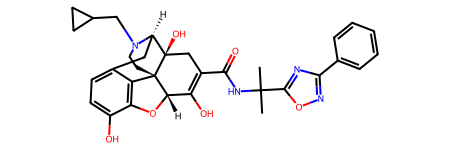

In [21]:
df.values[0][48]

In [22]:
df.values[0][3]

'Naldemedine'

In [23]:
failed = []
for row in df.values:
    os.mkdir(row[3])
    try:
        ligand_prep(row[48], out=f"{row[3]}/l")
    except Exception as e:
        os.removedirs(row[3])
        failed.append(row)

In [24]:
to_dock_dirs = [x for x in os.listdir() if x in df.name.to_list()]

In [27]:

for idx, dir_ in enumerate(tqdm(to_dock_dirs, total=len(to_dock_dirs))):
    if (idx>10 and idx%10 == 0):
        print('cooling down')
        time.sleep(50)
    
    if not os.path.exists(f'{dir_}/l_wild.dlg'):
        os.chdir(dir_)
        print(f"Docking in {dir_}")
        command = f"/home/ramin/Desktop/personal/cheminfo/adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild"
        try:
            
            result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(f"Command output: {result.stdout}")
            if result.stderr:
                print(f"Command stderr: {str(result.stderr)}")
        except subprocess.CalledProcessError as e:
            print(f"Command failed with error: {e}")
            print(f"Error output: {e.stderr}")

        os.chdir('../')  
    else:
        pass

  0%|          | 0/24 [00:00<?, ?it/s]

Docking in Naldemedine
Docking in Olmesartan
Docking in Gliquidone
Docking in Nelfinavir
Docking in Fedratinib
Docking in Troglitazone
Docking in Glyburide
Docking in Tirbanibulin
Docking in Cefamandole
Docking in Carindacillin
Docking in Empagliflozin
Docking in Cefamandole_nafate
Docking in Sotagliflozin
Docking in Fesoterodine
Docking in Elexacaftor
Docking in Cefazolin
Docking in Sofosbuvir
Docking in Copanlisib
Docking in Cisapride
Docking in Eliglustat
cooling down
Docking in Pimavanserin
Docking in Ertugliflozin
Docking in Amisulpride
Docking in Cefapirin


In [33]:
data = []
for dir__ in [x for x in os.listdir() if x in df.name.to_list()]:
    if os.path.exists(f'{dir__}/l_wild.dlg'):
        lines = []
        with open(f'{dir__}/l_wild.dlg') as f:
            lines = f.readlines()
        eng = [float(lines[idx+4].split("|")[3].strip()) for idx,x in enumerate(lines) if x.startswith('Clus')][0]
        data.append((dir__, eng))

In [34]:
data = pd.DataFrame.from_records([x for x in data], columns=['name', 'deltaG_ripk3'])

In [35]:
pd.merge(ligands_df, data, on="name").sort_values('deltaG_ripk3').to_csv('drug_ripk3.csv', index=False)

### pubchem

In [36]:
df = pd.read_csv('../../ripk_1/5hx6/pubchem_ripk1.csv')

In [43]:
df.head()

,SMILES,mol,mw,logp,hbd,hba,rd,exactmw,amw,lipinskiHBA,...,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi,pred_pic50,IC50,name,deltaG_ripk1
0,CCOc1ccc(-n2c(C)nnc2SCC(=O)NCc2ccccc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f7aaf85a8f0>,382.146347,3.38292,1,6,8,382.146347,382.489,6.0,...,2.569422,-2.80,18.975304,9.228022,5.103673,6.485353,7.020762,95.331748,pubchem_22,-10.62
1,CC(=O)Nc1cccc(OCc2noc(C(=O)NCCc3ccccc3)n2)c1,<rdkit.Chem.rdchem.Mol object at 0x7f7aae48ccf0>,380.148455,2.57950,2,8,8,380.148455,380.404,8.0,...,2.460260,-3.68,19.091889,9.312698,5.664705,6.349893,7.078489,83.466211,pubchem_14,-10.25
2,O=C(NCCOc1ccccc1)c1nc(Cc2ccccc2)n(-c2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7f7aae48cd60>,398.174276,3.66690,1,6,8,398.174276,398.466,6.0,...,3.038611,-3.93,19.389189,9.515239,4.911787,6.149759,7.463356,34.406738,pubchem_8,-10.18
3,Cc1ccc(C)c(-n2c(C)nnc2SCC(=O)NCCOc2ccccc2)c1,<rdkit.Chem.rdchem.Mol object at 0x7f7aae48cac0>,396.161997,3.47986,1,6,8,396.161997,396.516,6.0,...,2.731282,-2.80,19.947729,9.412510,5.132275,6.705650,7.186217,65.130242,pubchem_1,-10.05
4,Cc1cccc(OCCNC(=O)CSc2nnc(C)n2-c2ccccc2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7f7aae48c820>,396.161997,3.47986,1,6,8,396.161997,396.516,6.0,...,2.773669,-2.80,19.947729,9.412510,5.132275,6.705650,7.129888,74.150053,pubchem_4,-10.02


In [38]:
df = df.query('deltaG_ripk1 <= -8.84')

In [39]:
df.shape

(20, 54)

In [42]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

In [51]:
df.values[0][52]

'pubchem_22'

In [52]:
failed = []
for row in df.values:
    os.mkdir(row[52])
    try:
        ligand_prep(row[1], out=f"{row[52]}/l")
    except Exception as e:
        os.removedirs(row[52])
        failed.append(row)

In [53]:
to_dock_dirs = [x for x in os.listdir() if x in df.name.to_list()]

In [54]:
for idx, dir_ in enumerate(tqdm(to_dock_dirs, total=len(to_dock_dirs))):
    if (idx>10 and idx%10 == 0):
        print('cooling down')
        time.sleep(50)
    
    if not os.path.exists(f'{dir_}/l_wild.dlg'):
        os.chdir(dir_)
        print(f"Docking in {dir_}")
        command = f"/home/ramin/Desktop/personal/cheminfo/adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild"
        try:
            
            result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(f"Command output: {result.stdout}")
            if result.stderr:
                print(f"Command stderr: {str(result.stderr)}")
        except subprocess.CalledProcessError as e:
            print(f"Command failed with error: {e}")
            print(f"Error output: {e.stderr}")

        os.chdir('../')  
    else:
        pass

  0%|          | 0/20 [00:00<?, ?it/s]

Docking in pubchem_22
Docking in pubchem_14
Docking in pubchem_8
Docking in pubchem_1
Docking in pubchem_4
Docking in pubchem_13
Docking in pubchem_32
Docking in pubchem_6
Docking in pubchem_17
Docking in pubchem_7
Docking in pubchem_0
Docking in pubchem_20
Docking in pubchem_12
Docking in pubchem_16
Docking in pubchem_5
Docking in pubchem_31
Docking in pubchem_21
Docking in pubchem_27
Docking in pubchem_9
Docking in pubchem_11


In [55]:
data = []
for dir__ in [x for x in os.listdir() if x in df.name.to_list()]:
    if os.path.exists(f'{dir__}/l_wild.dlg'):
        lines = []
        with open(f'{dir__}/l_wild.dlg') as f:
            lines = f.readlines()
        eng = [float(lines[idx+4].split("|")[3].strip()) for idx,x in enumerate(lines) if x.startswith('Clus')][0]
        data.append((dir__, eng))

In [56]:
data = pd.DataFrame.from_records([x for x in data], columns=['name', 'deltaG_ripk3'])

,name,deltaG_ripk3
0,pubchem_22,-9.46
1,pubchem_14,-9.41
2,pubchem_8,-9.94
3,pubchem_1,-9.42
4,pubchem_4,-9.20
5,pubchem_13,-9.16
6,pubchem_32,-9.68
7,pubchem_6,-9.61
8,pubchem_17,-9.53
9,pubchem_7,-10.18


In [58]:
pd.merge(df, data, on="name").sort_values('deltaG_ripk3').to_csv('pubchem_ripk3.csv', index=False)

### Amines

In [9]:
! pwd

/home/ramin/Desktop/Thesis/ripk


In [10]:
os.chdir('ripk_3/6oko')

In [70]:
df = pd.read_csv('../../amin_post_sss.csv')

In [71]:
df_ = pd.read_csv('../../ripk_1/5hx6/amin_ripk1.csv')

In [72]:
df.head()

,Molecule,Canonical SMILES,Formula,MW,#Heavy atoms,#Aromatic heavy atoms,Fraction Csp3,#Rotatable bonds,#H-bond acceptors,#H-bond donors,...,Lipinski #violations,Ghose #violations,Veber #violations,Egan #violations,Muegge #violations,Bioavailability Score,PAINS #alerts,Brenk #alerts,Leadlikeness #violations,Synthetic Accessibility
0,Molecule 3,CNC(=O)c1cccc(c1)Cc1cc2nc(sc2cc1Cl)NC(=O)c1ccc...,C24H20ClN3O4S,481.95,33,21,0.12,8,5,3,...,0,1,0,0,0,0.55,0,0,3,3.39
1,Molecule 6,COc1nc(Cl)cc(c1)C(=O)Nc1nc2c(s1)cc(c(c2)Cc1ccc...,C23H18ClFN4O3S,484.93,33,21,0.13,8,6,2,...,0,1,0,0,1,0.55,0,1,3,3.48
2,Molecule 7,CNC(=O)c1cccc(c1)Cc1cc2nc(sc2cc1F)NC(=O)c1cccc...,C24H20FN3O4S2,497.56,34,21,0.12,8,6,2,...,0,1,1,1,0,0.55,0,0,3,3.62
3,Molecule 11,CNC(=O)c1cccc(c1)Cc1cc2nc(sc2cc1Cl)NC(=O)Cn1cc...,C22H19Cl2N5O2S,488.39,32,20,0.18,8,4,2,...,0,1,0,0,0,0.55,0,0,3,3.49
4,Molecule 13,CNC(=O)c1cccc(c1)Cc1cc2nc(sc2cc1F)NC(=O)COc1cc...,C24H19F2N3O3S,467.49,33,21,0.12,9,6,2,...,0,0,0,0,0,0.55,0,0,3,3.49


In [73]:
df = (df
 .rename(columns={'Canonical SMILES': 'SMILES'})
         )

In [74]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

In [75]:
df.SMILES = df.mol.apply(Chem.MolToSmiles)

In [76]:
df_ = df_.query('deltaG <= -8.84')

In [77]:
df = pd.merge(df, df_, on='SMILES')

In [78]:
df.head()

,Molecule,SMILES,Formula,MW,#Heavy atoms,#Aromatic heavy atoms,Fraction Csp3,#Rotatable bonds,#H-bond acceptors,#H-bond donors,...,hallKierAlpha,kappa1,kappa2,kappa3,Phi,mol_y,pred_pic50,IC50,name,deltaG
0,Molecule 3,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)c4ccc(OC)c(O)c4)s...,C24H20ClN3O4S,481.95,33,21,0.12,8,5,3,...,-3.62,22.569549,9.477399,4.916517,6.481837,<rdkit.Chem.rdchem.Mol object at 0x7538d56bb530>,7.408028,39.081601,amin_282,-12.32
1,Molecule 6,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)c4cc(Cl)nc(OC)c4)...,C23H18ClFN4O3S,484.93,33,21,0.13,8,6,2,...,-3.56,22.627434,9.514992,5.099490,6.524238,<rdkit.Chem.rdchem.Mol object at 0x7538d56b6ea0>,7.427124,37.400418,amin_122,-12.24
2,Molecule 7,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)c4ccccc4S(C)(=O)=...,C24H20FN3O4S2,497.56,34,21,0.12,8,6,2,...,-3.63,23.525576,9.317056,4.973384,6.446739,<rdkit.Chem.rdchem.Mol object at 0x7538d56bd1c0>,7.004447,98.981378,amin_346,-12.19
3,Molecule 11,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)Cn4cc(Cl)c(C)n4)s...,C22H19Cl2N5O2S,488.39,32,20,0.18,8,4,2,...,-2.94,22.260961,9.277680,4.929048,6.454065,<rdkit.Chem.rdchem.Mol object at 0x7538d56b8430>,7.032663,92.754958,amin_170,-12.10
4,Molecule 13,CNC(=O)c1cccc(Cc2cc3nc(NC(=O)COc4ccccc4F)sc3cc...,C24H19F2N3O3S,467.49,33,21,0.12,9,6,2,...,-3.85,22.347729,9.742595,5.320476,6.597724,<rdkit.Chem.rdchem.Mol object at 0x7538d56bad50>,7.629427,23.473266,amin_264,-12.08


In [79]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

In [80]:
df.values[0][96]

'amin_282'

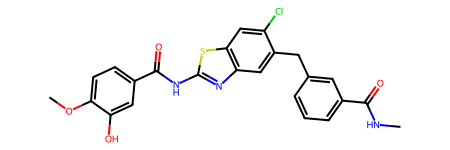

In [81]:
df.values[0][98]

In [37]:
failed = []
for row in df.values:
    os.mkdir(row[96])
    try:
        ligand_prep(row[98], out=f"{row[96]}/l")
    except Exception as e:
        os.removedirs(row[96])
        failed.append(row)

In [82]:
to_dock_dirs = [x for x in os.listdir() if x in df.name.to_list()]

In [40]:
import time

In [41]:
for idx, dir_ in enumerate(tqdm(to_dock_dirs, total=len(to_dock_dirs))):
    if (idx>10 and idx%10 == 0):
        print('cooling down')
        time.sleep(50)
    
    if not os.path.exists(f'{dir_}/l_wild.dlg'):
        os.chdir(dir_)
        print(f"Docking in {dir_}")
        command = f"/home/ramin/Desktop/personal/cheminfo/adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild"
        try:
            
            result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(f"Command output: {result.stdout}")
            if result.stderr:
                print(f"Command stderr: {str(result.stderr)}")
        except subprocess.CalledProcessError as e:
            print(f"Command failed with error: {e}")
            print(f"Error output: {e.stderr}")

        os.chdir('../')  
    else:
        pass

  0%|          | 0/207 [00:00<?, ?it/s]

Docking in amin_282
Docking in amin_122
Docking in amin_346
Docking in amin_170
Docking in amin_264
Docking in amin_349
Docking in amin_151
Docking in amin_294
Docking in amin_209
Docking in amin_284
Docking in amin_153
Docking in amin_171
Docking in amin_162
Docking in amin_290
Docking in amin_232
Docking in amin_195
Docking in amin_252
Docking in amin_50
Docking in amin_179
Docking in amin_251
cooling down
Docking in amin_85
Docking in amin_196
Docking in amin_193
Docking in amin_110
Docking in amin_221
Docking in amin_160
Docking in amin_355
Docking in amin_234
Docking in amin_245
Docking in amin_78
cooling down
Docking in amin_177
Docking in amin_295
Docking in amin_21
Docking in amin_324
Docking in amin_365
Docking in amin_235
Docking in amin_292
Docking in amin_253
Docking in amin_164
Docking in amin_197
cooling down
Docking in amin_112
Docking in amin_321
Docking in amin_203
Docking in amin_306
Docking in amin_181
Docking in amin_158
Docking in amin_223
Docking in amin_315
Docki

In [83]:
data = []
for dir__ in [x for x in os.listdir() if x in df.name.to_list()]:
    if os.path.exists(f'{dir__}/l_wild.dlg'):
        lines = []
        with open(f'{dir__}/l_wild.dlg') as f:
            lines = f.readlines()
        eng = [float(lines[idx+4].split("|")[3].strip()) for idx,x in enumerate(lines) if x.startswith('Clus')][0]
        data.append((dir__, eng))

In [84]:
data = pd.DataFrame.from_records([x for x in data], columns=['name', 'deltaG_ripk3'])

In [86]:
pd.merge(df, data, on="name").sort_values('deltaG_ripk3').to_csv('amin_ripk3.csv', index=False)

### trimethoxy

In [45]:
df = pd.read_csv('../../tri_post_sss.csv')

In [46]:
df_ = pd.read_csv('../../ripk_1/5hx6/tri_ripk1.csv')

In [47]:
df['mol'] = df['Canonical SMILES'].apply(Chem.MolFromSmiles)

In [48]:
df['SMILES'] = df.mol.apply(Chem.MolToSmiles)

In [50]:
df = pd.merge(df, df_, on='SMILES')

In [56]:
df.head()

,Molecule,Canonical SMILES,Formula,MW,#Heavy atoms,#Aromatic heavy atoms,Fraction Csp3,#Rotatable bonds,#H-bond acceptors,#H-bond donors,...,hallKierAlpha,kappa1,kappa2,kappa3,Phi,pred_pic50,IC50,name,deltaG,mol
0,Molecule 1,COc1cc(cc(c1OC)OC)C(=O)NCC(c1ccc2c(c1)cccc2)(C)C,C24H27NO4,393.48,29,16,0.29,8,4,1,...,-3.21,20.522360,8.432532,4.289064,5.967430,7.028547,93.638126,tri_202,-10.04,<rdkit.Chem.rdchem.Mol object at 0x7f39df708c10>
1,Molecule 2,COc1cc(cc(c1OC)OC)C(=O)NC1CCN(CC1)Cc1ccccc1C,C23H30N2O4,398.50,29,12,0.43,8,5,1,...,-2.73,20.990314,9.652126,5.008331,6.986247,7.128649,74.361949,tri_78,-10.01,<rdkit.Chem.rdchem.Mol object at 0x7f39df694430>
2,Molecule 3,COc1cc(cc(c1OC)OC)C(=O)NCC1(CC1)c1ccc(cc1)C(C)...,C24H31NO4,397.51,29,12,0.46,9,4,1,...,-2.69,21.029328,7.974174,4.337162,5.782466,7.533192,29.295999,tri_140,-9.97,<rdkit.Chem.rdchem.Mol object at 0x7f39df694270>
3,Molecule 4,COc1cc(cc(c1OC)OC)C(=O)NCC1CCN(CC1)Cc1ccccc1,C23H30N2O4,398.50,29,12,0.43,9,5,1,...,-2.73,20.990314,10.163139,5.414773,7.356120,7.354357,44.222494,tri_14,-9.93,<rdkit.Chem.rdchem.Mol object at 0x7f39df6945f0>
4,Molecule 5,COc1cc(cc(c1OC)OC)C(=O)NCC1CCN(CC1)CC1CCCC1,C22H34N2O4,390.52,28,6,0.68,9,5,1,...,-1.95,20.775786,10.007568,5.100923,7.425539,7.081670,82.857097,tri_234,-9.84,<rdkit.Chem.rdchem.Mol object at 0x7f39df6943c0>


In [52]:
df.values[0][102]

'tri_202'

In [55]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

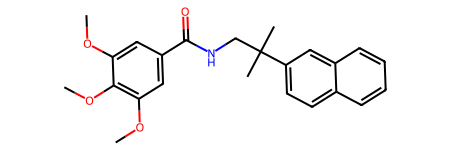

In [57]:
df.values[0][104]

In [59]:
failed = []
for row in df.values:
    os.mkdir(row[102])
    try:
        ligand_prep(row[104], out=f"{row[102]}/l")
    except Exception as e:
        os.removedirs(row[102])
        failed.append(row)

FileExistsError: [Errno 17] File exists: 'tri_39'

In [60]:
to_dock_dirs = [x for x in os.listdir() if x in df.name.to_list()]

In [62]:
for idx, dir_ in enumerate(tqdm(to_dock_dirs, total=len(to_dock_dirs))):
    if (idx>10 and idx%10 == 0):
        print('cooling down')
        time.sleep(50)
    
    if not os.path.exists(f'{dir_}/l_wild.dlg'):
        os.chdir(dir_)
        print(f"Docking in {dir_}")
        command = f"/home/ramin/Desktop/personal/cheminfo/adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild"
        try:
            
            result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(f"Command output: {result.stdout}")
            if result.stderr:
                print(f"Command stderr: {str(result.stderr)}")
        except subprocess.CalledProcessError as e:
            print(f"Command failed with error: {e}")
            print(f"Error output: {e.stderr}")

        os.chdir('../')  
    else:
        pass

  0%|          | 0/41 [00:00<?, ?it/s]

Docking in tri_202
Docking in tri_78
Docking in tri_140
Docking in tri_14
Docking in tri_234
Docking in tri_176
Docking in tri_141
Docking in tri_79
Docking in tri_189
Docking in tri_98
Docking in tri_75
Docking in tri_231
Docking in tri_32
Docking in tri_81
Docking in tri_135
Docking in tri_193
Docking in tri_182
Docking in tri_137
Docking in tri_43
Docking in tri_33
cooling down
Docking in tri_46
Docking in tri_5
Docking in tri_272
Docking in tri_194
Docking in tri_196
Docking in tri_276
Docking in tri_149
Docking in tri_275
Docking in tri_82
Docking in tri_197
cooling down
Docking in tri_77
Docking in tri_80
Docking in tri_29
Docking in tri_172
Docking in tri_51
Docking in tri_143
Docking in tri_244
Docking in tri_165
Docking in tri_74
Docking in tri_39
cooling down
Docking in tri_16


In [65]:
data = []
for dir__ in [x for x in os.listdir() if x in df.name.to_list()]:
    if os.path.exists(f'{dir__}/l_wild.dlg'):
        lines = []
        with open(f'{dir__}/l_wild.dlg') as f:
            lines = f.readlines()
        eng = [float(lines[idx+4].split("|")[3].strip()) for idx,x in enumerate(lines) if x.startswith('Clus')][0]
        data.append((dir__, eng))

In [66]:
data = pd.DataFrame.from_records([x for x in data], columns=['name', 'deltaG_ripk3'])

In [69]:
pd.merge(df, data, on="name").sort_values('deltaG_ripk3').to_csv('tri_ripk3.csv', index=False)

### GSK-772

In [87]:
os.chdir('gsk_772/')

In [89]:
! adgpu --lfile l.pdbqt --ffile ../r.maps.fld --nrun 50 --resnam l_wild

AutoDock-GPU version: v1.6

Running 1 docking calculation

ERROR in cudaGetDeviceCount: initialization error
adgpu: ./host/src/performdocking.cpp:433: void setup_gpu_for_docking(GpuData&, GpuTempData&): Assertion `0' failed.


In [92]:
os.chdir('../')

In [100]:
df = pd.read_csv('./tri_ripk3.csv')

In [101]:
df.head()

,Molecule,Canonical SMILES,Formula,MW,#Heavy atoms,#Aromatic heavy atoms,Fraction Csp3,#Rotatable bonds,#H-bond acceptors,#H-bond donors,...,kappa1,kappa2,kappa3,Phi,pred_pic50,IC50,name,deltaG,mol,deltaG_ripk3
0,Molecule 22,COc1cc(cc(c1OC)OC)C(=O)NCC1(CCCC1)c1cc(C)cc(c1)C,C24H31NO4,397.51,29,12,0.46,8,4,1,...,21.029328,8.764995,4.337162,6.355930,7.329547,46.822387,tri_182,-9.50,<rdkit.Chem.rdchem.Mol object at 0x7f39df694b30>,-9.26
1,Molecule 1,COc1cc(cc(c1OC)OC)C(=O)NCC(c1ccc2c(c1)cccc2)(C)C,C24H27NO4,393.48,29,16,0.29,8,4,1,...,20.522360,8.432532,4.289064,5.967430,7.028547,93.638126,tri_202,-10.04,<rdkit.Chem.rdchem.Mol object at 0x7f39df708c10>,-9.17
2,Molecule 12,COc1cc(cc(c1OC)OC)C(=O)NCC1CCN(CC1)C1CCCCC1,C22H34N2O4,390.52,28,6,0.68,8,5,1,...,20.775786,10.007568,4.903040,7.425539,7.072964,84.534854,tri_98,-9.66,<rdkit.Chem.rdchem.Mol object at 0x7f39df6947b0>,-9.15
3,Molecule 10,COc1cc(cc(c1OC)OC)C(=O)NC1CCN(CC1)Cc1cccc(c1)C,C23H30N2O4,398.50,29,12,0.43,8,5,1,...,20.990314,9.652126,5.205607,6.986247,7.011860,97.306002,tri_79,-9.72,<rdkit.Chem.rdchem.Mol object at 0x7f39df694350>,-9.12
4,Molecule 18,COc1cc(cc(c1OC)OC)C(=O)NCCCCN1CCc2c(C1)cccc2,C23H30N2O4,398.50,29,12,0.43,10,5,1,...,20.990314,10.163139,5.205607,7.356120,7.197450,63.467273,tri_81,-9.56,<rdkit.Chem.rdchem.Mol object at 0x7f39df6949e0>,-9.08


In [102]:
df[['SMILES', 'name', 'deltaG', 'deltaG_ripk3', 'IC50']] 

,SMILES,name,deltaG,deltaG_ripk3,IC50
0,COc1cc(C(=O)NCC2(c3cc(C)cc(C)c3)CCCC2)cc(OC)c1OC,tri_182,-9.50,-9.26,46.822387
1,COc1cc(C(=O)NCC(C)(C)c2ccc3ccccc3c2)cc(OC)c1OC,tri_202,-10.04,-9.17,93.638126
2,COc1cc(C(=O)NCC2CCN(C3CCCCC3)CC2)cc(OC)c1OC,tri_98,-9.66,-9.15,84.534854
3,COc1cc(C(=O)NC2CCN(Cc3cccc(C)c3)CC2)cc(OC)c1OC,tri_79,-9.72,-9.12,97.306002
4,COc1cc(C(=O)NCCCCN2CCc3ccccc3C2)cc(OC)c1OC,tri_81,-9.56,-9.08,63.467273
5,COc1cc(C(=O)NCC2(Cc3cccnc3)CCCCC2)cc(OC)c1OC,tri_272,-9.36,-9.01,59.183752
6,COc1cc(C(=O)NCc2cc(-c3ccc(C)cc3)cs2)cc(OC)c1OC,tri_193,-9.50,-8.97,88.397160
7,COc1cc(C(=O)NCc2ccc(OC3CCCCC3)cc2)cc(OC)c1OC,tri_33,-9.46,-8.97,85.781375
8,COc1cc(C(=O)NC2CCN(CCc3ccccc3)CC2)cc(OC)c1OC,tri_43,-9.49,-8.93,85.487084
9,COc1cc(C(=O)NCC2CCN(CC3CCCC3)CC2)cc(OC)c1OC,tri_234,-9.84,-8.92,82.857097
